In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -U tensorflow_datasets

     |████████████████████████████████| 3.7 MB 1.2 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 3.0.0
    Uninstalling tensorflow-datasets-3.0.0:
      Successfully uninstalled tensorflow-datasets-3.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-cloud 0.1.13 requires tensorflow-datasets<3.1.0, but you have tensorflow-datasets 4.2.0 which is incompatible.


In [3]:
import tensorflow as tf

In [4]:
# Import Tensorflow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Hepler Libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Import Fashion MNIST datsets

In [6]:
dataset, metdata = tfds.load('fashion_mnist', as_supervised = True, with_info = True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [7]:
class_name = metdata.features['label'].names
print('Class Names: {}'.format(class_name))

Class Names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


**Explore the data**

In [8]:
num_train_examples = metdata.splits['train'].num_examples
num_test_examples = metdata.splits['test'].num_examples

print('Number of training examples: {}'.format(num_train_examples))
print('Number of test examples: {}'.format(num_test_examples))

Number of training examples: 60000
Number of test examples: 10000


**Preprocess the data**

In [9]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

In [10]:
# Map the function applies the normalize function to each elemets in the train and test datasets

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

In [11]:
# First time you use the datasets, the images will be loaded from disk Caching will keep them in memory, making training faster

train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

**Explore the processed data**

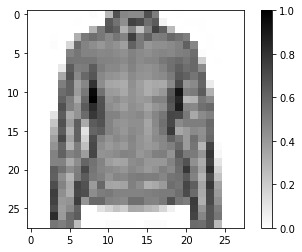

In [12]:
# Take a single image, and remove the color dimension by reshaping 
for image, label in test_dataset.take(1):
    break
image - image.numpy().reshape((28,28))

# Plot the image - voile a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap= plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

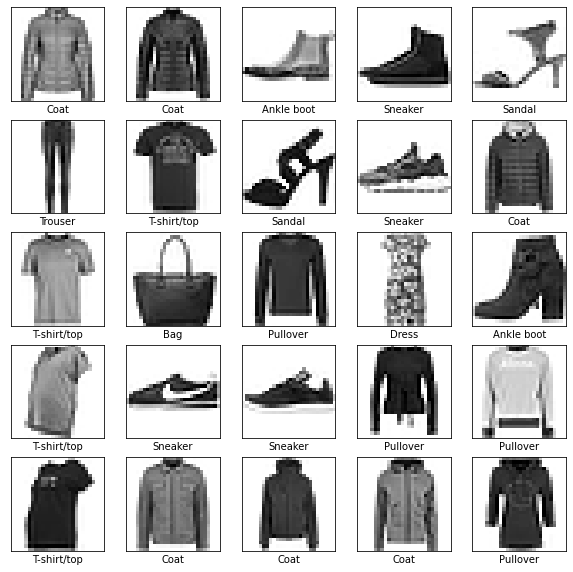

In [13]:
plt.figure(figsize = (10,10))
for i, (image, label) in enumerate(test_dataset.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap = plt.cm.binary)
    plt.xlabel(class_name[label])
plt.show()

# Bulid The Model

**Layers Setup** 

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (28,28,1)),
    tf.keras.layers.Dense(128, activation = tf.nn.relu),
    tf.keras.layers.Dense(10,activation = tf.nn.softmax)
])

**Complie the model**

In [15]:
model.compile(optimizer = 'adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics = ['accuracy'])

**Train the Model**

In [16]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [17]:
model.fit(train_dataset, epochs = 5, steps_per_epoch = math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 8s 2ms/step - loss: 0.6204 - accuracy: 0.7837
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3773 - accuracy: 0.8643
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3397 - accuracy: 0.8773
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3088 - accuracy: 0.8888
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2990 - accuracy: 0.8895


**Evaluate accuracy**

In [18]:
test_loss, test_accuracy = model.evaluate(test_dataset,steps = math.ceil(num_test_examples / 32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 1s 4ms/step - loss: 0.3474 - accuracy: 0.8747
Accuracy on test dataset: 0.8747000098228455


# Make Predictions

In [19]:
for test_images, test_labels in test_dataset.take(1):
    test_images =test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)

In [20]:
predictions.shape

(32, 10)

In [21]:
predictions[0]

array([7.5416856e-06, 1.3111556e-05, 6.2188664e-03, 7.0012265e-07,
       9.6860135e-01, 1.2534616e-10, 2.5156062e-02, 3.5815778e-10,
       2.2680667e-06, 1.0922097e-09], dtype=float32)

In [22]:
np.argmax(predictions[0])

4

In [23]:
test_labels[0]

4

In [24]:
def plot_image(i, predictions_array, ture_labels, images):
    predictions_array, true_label, img = predictions_array[i], ture_labels[i],images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img[...,0], cmap = plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_name[predicted_label],
                                         100*np.max(predictions_array),
                                         class_name[true_label]),
               color=color)
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
  
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

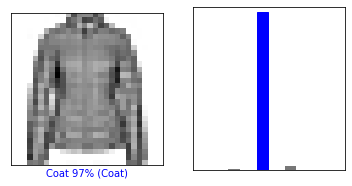

In [25]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

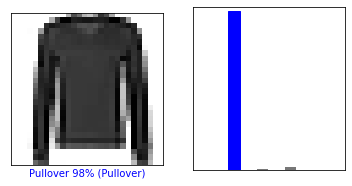

In [26]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

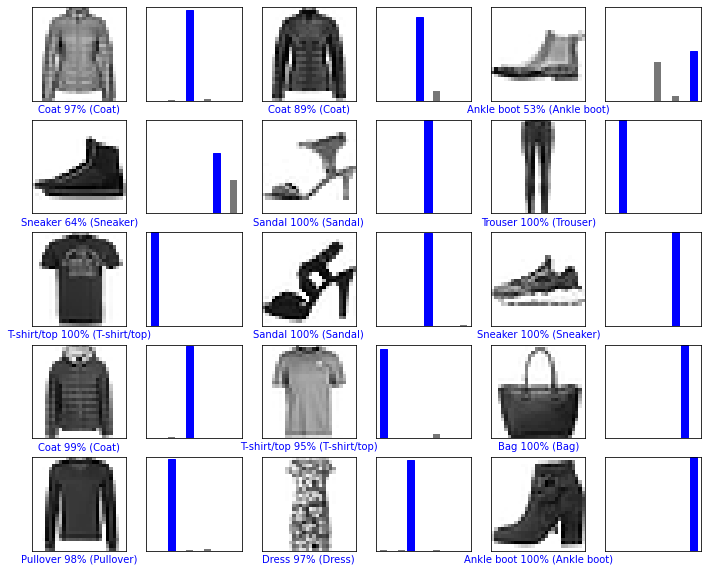

In [27]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)


In [28]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [29]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [30]:
predictions_single = model.predict(img)

print(predictions_single)

[[7.5416715e-06 1.3111556e-05 6.2188548e-03 7.0012129e-07 9.6860135e-01
  1.2534616e-10 2.5156057e-02 3.5815709e-10 2.2680622e-06 1.0922077e-09]]


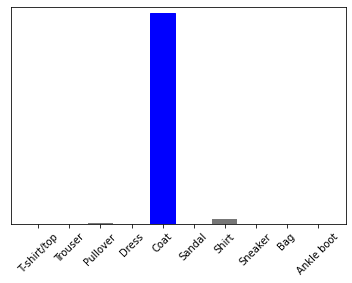

In [31]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_name, rotation=45)

In [32]:
np.argmax(predictions_single[0])

4